In [2]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import nibabel as nib
import scipy
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import copy
import glob
sys.path.insert(1, '/export03/data/opt/Hippo_Spin_Testing')
from hippo_spin_testing import spin_test
sys.path.insert(1, '/data/mica1/01_programs/micapipe-v0.2.0/functions')
from build_mpc import build_mpc
from brainspace.gradient import GradientMaps
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
# get a list of all files to examine

files = []
for hemi in ['mix','L']: files.extend(glob.glob(f'../maps/*_average-*_hemi-{hemi}_den-*_label-hipp.shape.gii'))
files = list(set(files) - set(glob.glob(f'../maps/*FCG1to5_average-*_hemi-*_den-*_label-hipp.shape.gii')))
files.sort(reverse=True)
for f in ['curvature','gyrification','thickness']:
    for fn in files: 
        if f in fn:
            files.remove(fn)
            files.append(fn)

In [3]:
# organize into sensible blocks of the same modality

blocks_len = [8,3,8,6,9]
blocks = np.concatenate(([0],np.cumsum(blocks_len)))

# organize histo
order=[3,2,7,5,4,0,1,6]
files[blocks[0]:blocks[1]] = [files[blocks[0]:blocks[1]][i] for i in order]
# organize PLI
order=[1,0,2]
files[blocks[1]:blocks[2]] = [files[blocks[1]:blocks[2]][i] for i in order]
# organize 7T
order=[3,6,7,0,1,2,4,5]
files[blocks[2]:blocks[3]] = [files[blocks[2]:blocks[3]][i] for i in order]
# organize 3T
order=[3,4,5,0,1,2]
files[blocks[3]:blocks[4]] = [files[blocks[3]:blocks[4]][i] for i in order]
# organize morphology
order=[1,0,2,4,3,5,7,6,8]
files[blocks[4]:blocks[5]] = [files[blocks[4]:blocks[5]][i] for i in order]

In [4]:
# load all data

features = []
cdata = np.ones((7262,len(files)))
for f in range(len(files)):
    features.append(files[f][8:].split('_')[0])
    den = files[f][8:].split('_')[3][4:]
    cdata[:,f],_,_ = utils.density_interp(den,'0p5mm',nib.load(files[f]).darrays[0].data, label='hipp')

In [5]:
# check for significant correlation (spin test) (slow!)

feat_corr_p = np.ones((len(features),len(features)))
for i in range(len(features)):
    for j in range(i+1,len(features)):
        _,_,feat_corr_p[i,j],_ = spin_test.spin_test(cdata[:,i],cdata[:,j], 1000, space='orig')

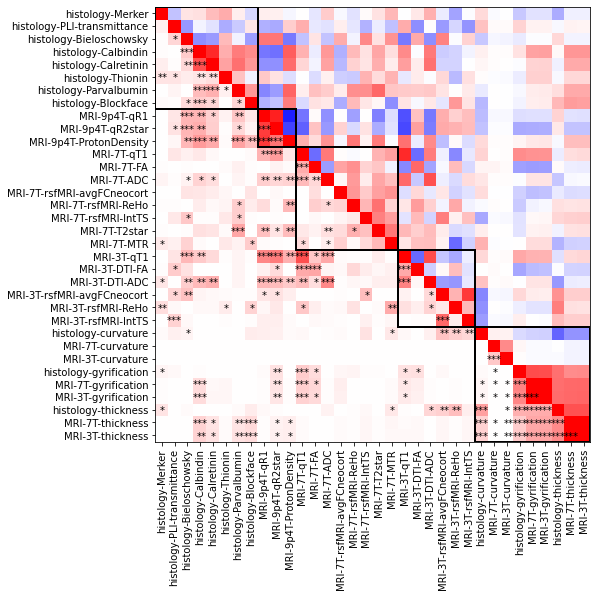

In [16]:
# plot correlation between features

feat_corr = np.corrcoef(cdata.T)

# bottom left will show Rsquared
iloc = np.tril_indices(len(feat_corr))
feat_corr[iloc] = feat_corr[iloc]**2

# plot and label
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(features)),labels=features);
plt.xticks(ticks=range(len(features)),labels=features, rotation=90);

# box around same modality
for i in range(len(blocks)-1):
    w = blocks[i+1]-blocks[i]
    rect = Rectangle((blocks[i]-.5,blocks[i]-.5),w,w, linewidth=2, edgecolor='k', facecolor='none')
    ax.add_patch(rect)

# annotate significant correlations
for i in range(len(features)):
    for j in range(i+1,len(features)):
        if feat_corr_p[i,j] < 0.001:
            plt.annotate('***', (i-.6,j+.3));
        elif feat_corr_p[i,j] < 0.01:
            plt.annotate('**', (i-.3,j+.3));
        elif feat_corr_p[i,j] < 0.05:
            plt.annotate('*', (i-.15,j+.3));

In [114]:
# currently there is a bug where 9 plots are not allowed, but 10 are, so we add an extra empty plot
cdata = np.concatenate((cdata,np.ones((cdata.shape[0],1))*np.nan),axis=1)
blocks[-1] = blocks[-1]+1

cdata all NaN


/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/utils.py:303: RuntimeWarning: All-NaN axis encountered
  a, b = np.nanmin(x), np.nanmax(x)
/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/utils.py:367: RuntimeWarning: All-NaN slice encountered
  specs['min'][:] = np.nanmin(specs['min'], axis=ax, keepdims=True)
/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/utils.py:368: RuntimeWarning: All-NaN slice encountered
  specs['max'][:] = np.nanmax(specs['max'], axis=ax, keepdims=True)


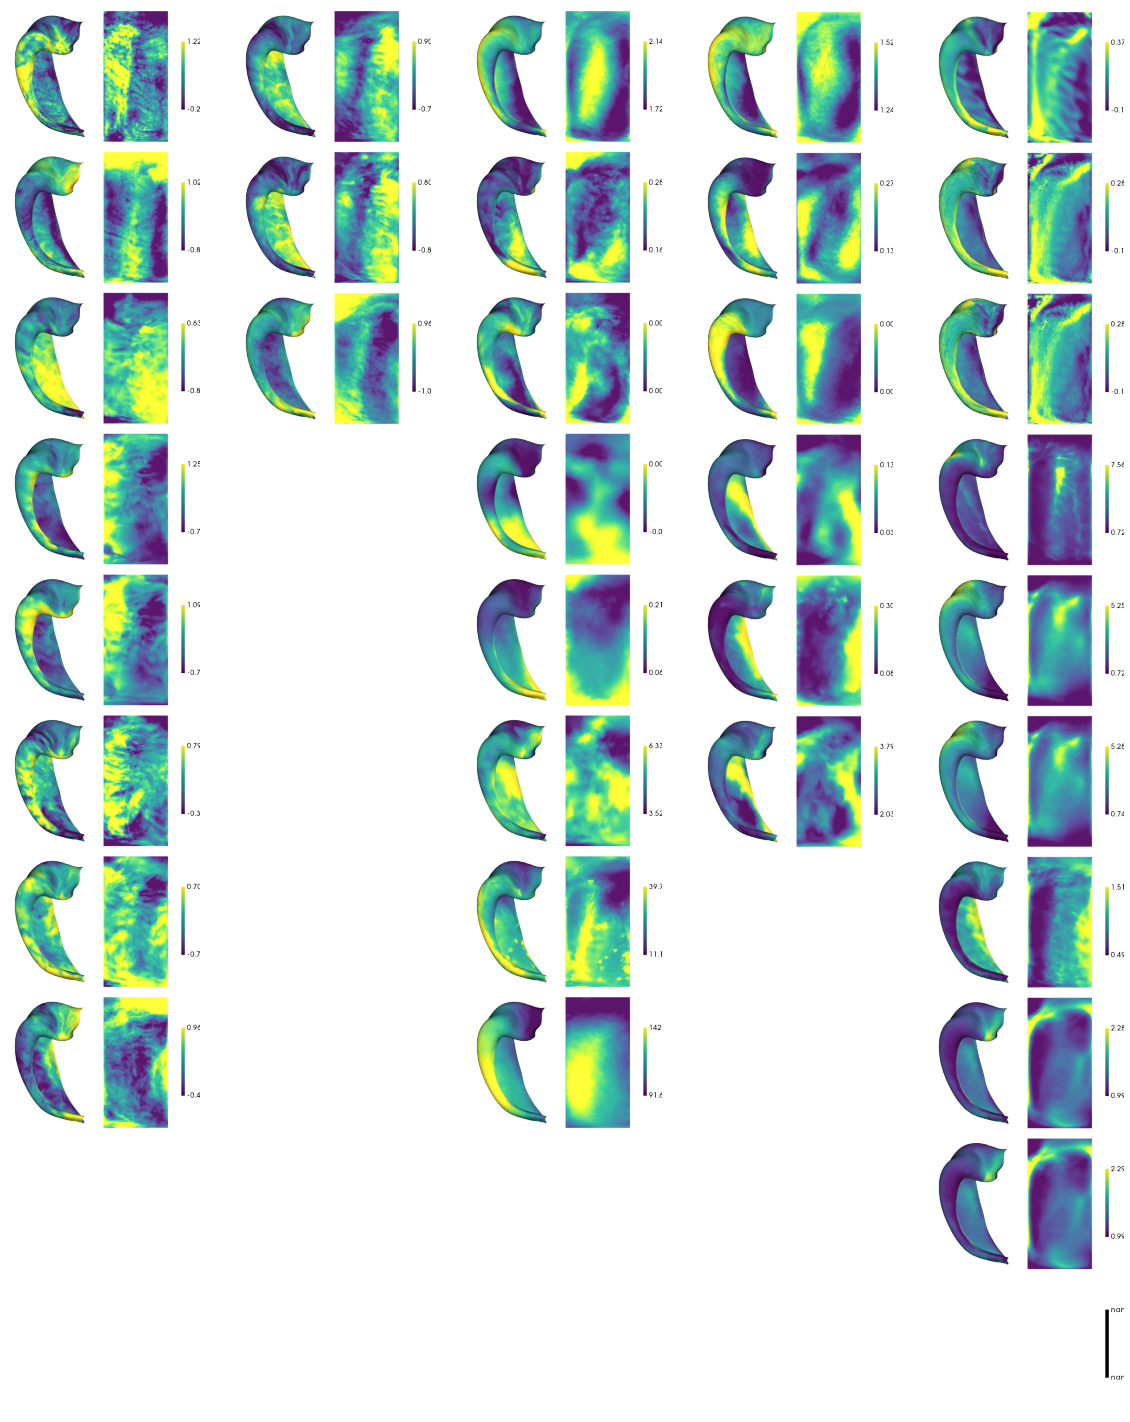

In [115]:
# plot all feature maps in the same plot

fig, ax = plt.subplots(1,5, figsize=(20,50))
for b in range(5):
    plotting.surfplot_canonical_foldunfold(cdata[:,blocks[b]:blocks[b+1]], color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True, screenshot=True, filename='tmp.png')
    f = plt.imread('tmp.png')
    ax[b].imshow(f)
    ax[b].set_axis_off()
    ax[b].set_anchor("NW")

In [116]:
cdata = cdata[:,:-1]

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


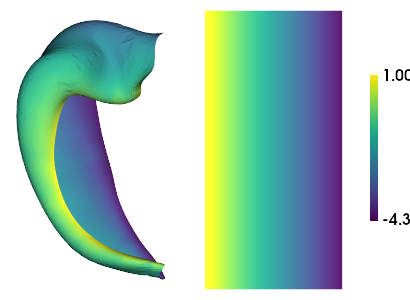

In [8]:
subfields = nib.load('/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0_supersession/hippunfold/sub-PNC002/surf/sub-PNC002_hemi-L_space-T1w_den-0p5mm_label-hipp_atlas-histologyReference2023_subfields.label.gii').darrays[0].data
AP,_,_ = utils.density_interp('unfoldiso','0p5mm',repmat(np.linspace(0,1,254),126,1).flatten(), label='hipp')
PD,_,_ = utils.density_interp('unfoldiso','0p5mm',repmat(np.linspace(0,1,126),254,1).T.flatten(), label='hipp')
plotting.surfplot_canonical_foldunfold(PD, color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=False, embed_nb=True)

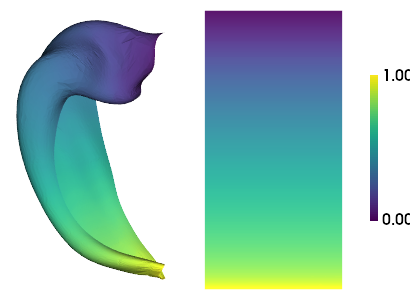

In [9]:
plotting.surfplot_canonical_foldunfold(AP, color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=False, embed_nb=True)

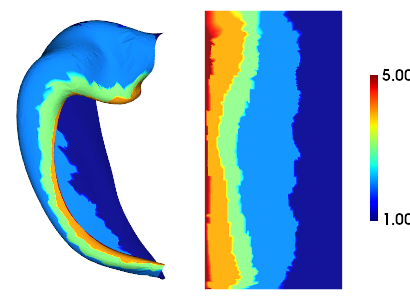

In [117]:
plotting.surfplot_canonical_foldunfold(subfields, color_bar=('right'), hemis=['L'], labels=['hipp'], cmap='jet', unfoldAPrescale=True, share='row', tighten_cwindow=False, embed_nb=True)

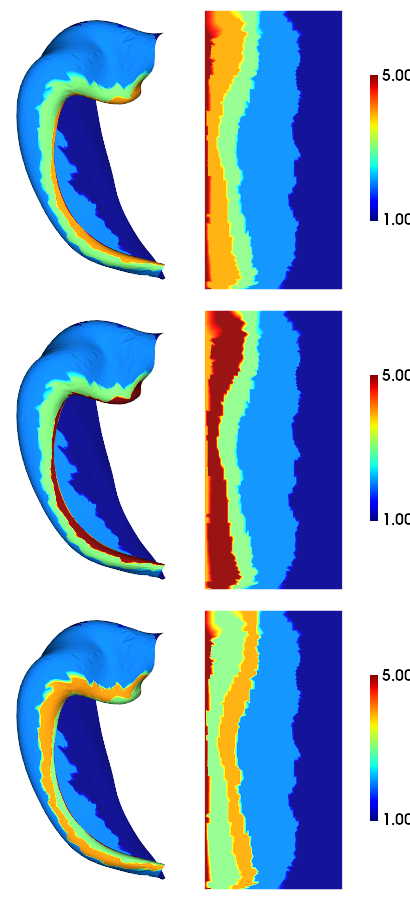

In [118]:
from itertools import permutations 
perms = list(permutations([1,2,3,4,5]))
subfields_permuted = np.ones((len(subfields),len(perms)))*np.nan
for p in range(len(perms)):
    newsf = np.ones((len(subfields)))*np.nan
    for s in range(5):
        newsf[subfields==s+1] = perms[p][s]
    subfields_permuted[:,p] = newsf
plotting.surfplot_canonical_foldunfold(subfields_permuted[:,:3], color_bar=('right'), hemis=['L'], labels=['hipp'], cmap='jet',  unfoldAPrescale=True, share='row', tighten_cwindow=False, embed_nb=True)

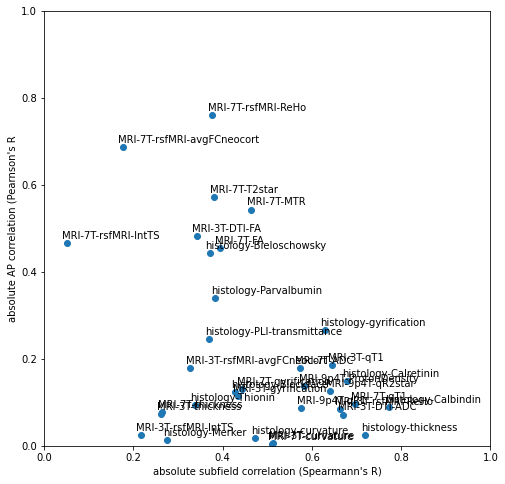

In [110]:
from scipy.stats import spearmanr
subfieldscorr = np.abs(spearmanr(np.concatenate((cdata,subfields_permuted),axis=1))[0][34:,:34])
subfieldsmaxcorr = np.max(subfieldscorr,axis=0)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(subfieldsmaxcorr,axiscorr[0],)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("absolute subfield correlation (Spearmann's R)")
plt.ylabel("absolute AP correlation (Pearnson's R")
for f,feature in enumerate(features):
    ax.annotate(feature, (subfieldsmaxcorr[f]-0.01, axiscorr[0,f]+.01))

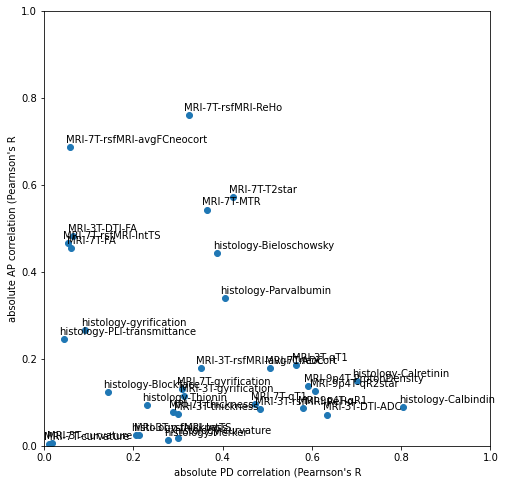

In [111]:
subfieldscorr = np.abs(np.corrcoef(np.concatenate((cdata,subfields_permuted),axis=1).T)[34:,:34])

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(axiscorr[1],axiscorr[0])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("absolute PD correlation (Pearnson's R")
plt.ylabel("absolute AP correlation (Pearnson's R")
for f,feature in enumerate(features):
    ax.annotate(feature, (axiscorr[1,f]-0.01, axiscorr[0,f]+.01))

In [72]:
axiscorr = np.abs(np.corrcoef(np.concatenate((cdata,AP.reshape(7262,1),PD.reshape(7262,1)),axis=1).T)[34:,:34])

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(axiscorr[0],axiscorr[1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('AP')
plt.ylabel('PD')
for f,feature in enumerate(features):
    ax.annotate(feature, (axiscorr[0,f]+.01, axiscorr[1,f]

['histology-Merker',
 'histology-PLI-transmittance',
 'histology-Bieloschowsky',
 'histology-Calbindin',
 'histology-Calretinin',
 'histology-Thionin',
 'histology-Parvalbumin',
 'histology-Blockface',
 'MRI-9p4T-qR1',
 'MRI-9p4T-qR2star',
 'MRI-9p4T-ProtonDensity',
 'MRI-7T-qT1',
 'MRI-7T-FA',
 'MRI-7T-ADC',
 'MRI-7T-rsfMRI-avgFCneocort',
 'MRI-7T-rsfMRI-ReHo',
 'MRI-7T-rsfMRI-IntTS',
 'MRI-7T-T2star',
 'MRI-7T-MTR',
 'MRI-3T-qT1',
 'MRI-3T-DTI-FA',
 'MRI-3T-DTI-ADC',
 'MRI-3T-rsfMRI-avgFCneocort',
 'MRI-3T-rsfMRI-ReHo',
 'MRI-3T-rsfMRI-IntTS',
 'histology-curvature',
 'MRI-7T-curvature',
 'MRI-3T-curvature',
 'histology-gyrification',
 'MRI-7T-gyrification',
 'MRI-3T-gyrification',
 'histology-thickness',
 'MRI-7T-thickness',
 'MRI-3T-thickness']

In [60]:
AP.reshape(7262,1).shape

(7262, 1)

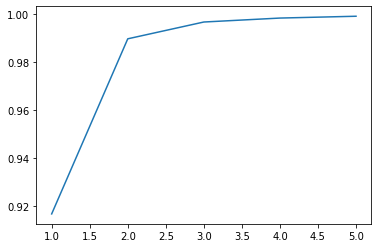

In [24]:
pca = PCA()
principalComponents = pca.fit_transform(cdata)
plt.plot(np.arange(5)+1, np.cumsum(pca.explained_variance_ratio_[:5]))

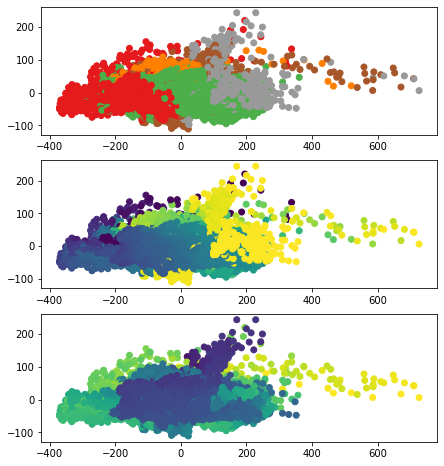

In [52]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 8))
ax[0].scatter(principalComponents[:,0], principalComponents[:,1], c=subfields, cmap='Set1')
ax[0].set_aspect('equal', 'box')
ax[1].scatter(principalComponents[:,0], principalComponents[:,1], c=PD)
ax[1].set_aspect('equal', 'box')
ax[2].scatter(principalComponents[:,0], principalComponents[:,1], c=AP)
ax[2].set_aspect('equal', 'box')

In [ ]:
# gradient decomposition
ngrads=5
mmgm = GradientMaps(n_components=ngrads, kernel='cosine', random_state=0)
mmgm.fit(cdata, sparsity=0.1)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


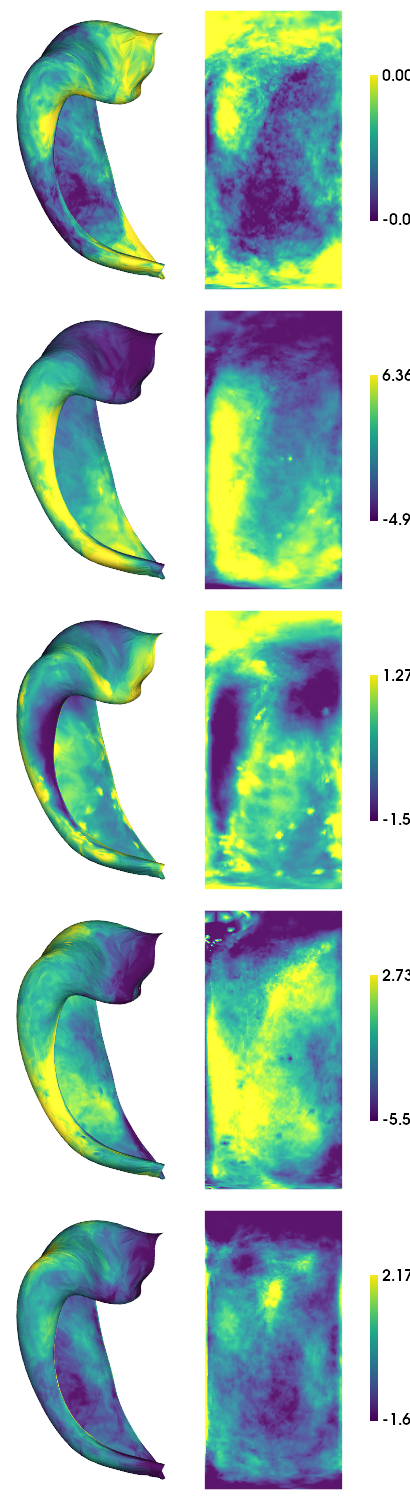

In [6]:
plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], unfoldAPrescale=True, color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

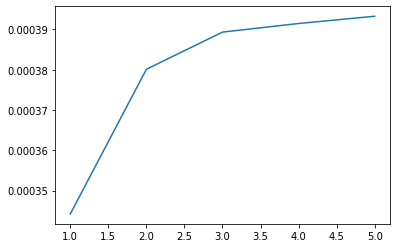

In [7]:
plt.plot(np.arange(ngrads)+1,np.cumsum(mmgm.lambdas_))

In [34]:
# save everything
import shelve
filename='../checkpoints/DimReduct.out'
my_shelf = shelve.open(filename,'n') # 'n' for new
for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

ERROR shelving: __builtin__
ERROR shelving: __builtins__
ERROR shelving: copy
ERROR shelving: exit
ERROR shelving: get_ipython
ERROR shelving: glob
ERROR shelving: my_shelf
ERROR shelving: nib
ERROR shelving: np
ERROR shelving: plotting
ERROR shelving: plt
ERROR shelving: quit
ERROR shelving: scipy
ERROR shelving: shelve
ERROR shelving: spin_test
ERROR shelving: sys
ERROR shelving: utils


In [113]:
# load everything
import shelve
filename='../checkpoints/DimReduct.out'
my_shelf = shelve.open(filename)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()

## include liminae

In [ ]:
downsampled_histo = np.load("../checkpoints/struct-HISTO-proc-averaged.npy")
cdata = np.load("../checkpoints/struct-PNI-averaged.npy")
struct_data = np.concatenate((downsampled_histo,cdata),axis=2)

allfeatures = ['Merker', 'PLI-transmittance', 'Blockface', 'Bieloschowsky', 'Calbindin', 'Calretinin', 'Parvalbumin', 'Thionin', 'ProtonDensity', 'qR1', 'qR2star', \
               'T1map', 'MTR', 'T2star', 'FA', 'ADC']

In [ ]:
# correlation between features
feat_corr = np.corrcoef(struct_data.reshape(7262*17,16).T)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(allfeatures)),labels=allfeatures);
plt.xticks(ticks=range(len(allfeatures)),labels=allfeatures, rotation=90);

In [ ]:
# correlation between features
feat_corr = np.corrcoef(np.nanmean(struct_data,axis=1).T)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(allfeatures)),labels=allfeatures);
plt.xticks(ticks=range(len(allfeatures)),labels=allfeatures, rotation=90);

In [ ]:
feat_corr_correct_R = np.zeros((len(allfeatures),len(allfeatures)))
feat_corr_correct_p = np.zeros((len(allfeatures),len(allfeatures)))
for i in range(len(allfeatures)):
    for j in range(i+1,len(allfeatures)):
        _,_,feat_corr_correct_p[i,j],feat_corr_correct_R[i,j] = spin_test.spin_test(np.nanmean(struct_data[:,:,i],axis=1),np.nanmean(struct_data[:,:,j],axis=1), 1000, space='orig')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr_correct_R, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(allfeatures)),labels=allfeatures);
plt.xticks(ticks=range(len(allfeatures)),labels=allfeatures, rotation=90);

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr_correct_p, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(allfeatures)),labels=allfeatures);
plt.xticks(ticks=range(len(allfeatures)),labels=allfeatures, rotation=90);

In [ ]:
# gradient decomposition
ngrads=5
mmgm = GradientMaps(n_components=ngrads, kernel='cosine', random_state=0)
mmgm.fit(struct_data.reshape(7262,17*16), sparsity=0.1)
plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], unfoldAPrescale=True, color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

In [ ]:
plt.plot(np.arange(ngrads)+1,mmgm.lambdas_)